In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

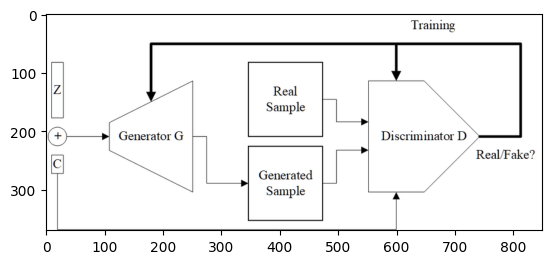

In [10]:
img = cv2.imread("cond_gan.png")
plt.imshow(img)

In [1]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, img_channels,num_classes,img_size):
        super().__init__()
        self.img_size = img_size
        self.embedding = nn.Embedding(num_classes,img_size*img_size) #but the input acepted is just class number one hot should be converted to class number
        self.disc = nn.Sequential(
            self.block(input_channels + 1, img_channels, 4, 2, 1), #increase 1 channel
            self.block(img_channels, img_channels * 2, 4, 2, 1),
            self.block(img_channels * 2, img_channels * 4, 4, 2, 1),
            self.block(img_channels * 4, img_channels * 8, 4, 2, 1),
            nn.Conv2d(img_channels * 8, 1, 4, 2, 0),
            nn.Sigmoid()
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x,labels): # x = N x input_channels x img_size x img_size
        embed = self.embedding(labels).reshape(-1,1,self.img_size,self.img_size) #-1 here it means batch size
        x = torch.cat([x, embed], dim=1) #effectively making 4 channels for rgb 2 for greyscale
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, latent_dim,embed_dim, input_channels, img_channels,num_classes,img_size):
        super().__init__()
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(num_classes,embed_dim)
        self.gen = nn.Sequential(
            self.block(latent_dim+embed_dim, img_channels * 16, 4, 1, 0),#latent_dim = N xlatent_dim x1x1
            self.block(img_channels * 16, img_channels * 8, 4, 2, 1),
            self.block(img_channels * 8, img_channels * 4, 4, 2, 1),
            self.block(img_channels * 4, img_channels * 2, 4, 2, 1),
            nn.ConvTranspose2d(img_channels * 2, input_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x ,labels):
        embed = self.embedding(labels).reshape(x.shape[0], self.embed_dim, 1,1)
        x = torch.cat([x,embed],dim = 1)  # for 2nd portion
        return self.gen(x)



class cond_DCGAN():
    def __init__(self, latent_dim,embed_dim, input_channels, img_channels, batch_size,num_classes,img_size):
        self.discriminator = Discriminator(input_channels, img_channels, num_classes,img_size)
        self.generator = Generator(latent_dim,embed_dim,input_channels, img_channels,num_classes,img_size)
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.img_channels = img_channels
        self.batch_size = batch_size

        self.device = torch.device("cuda")
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def train(self, x_train, k_steps=2, lr=1e-4, max_epochs=20):
        optim_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
        optim_generator = optim.Adam(self.generator.parameters(), lr=lr)
        criterion = nn.BCELoss()
        error_discriminator = []
        error_generator = []

        for epoch in range(max_epochs):
            sum1 = torch.tensor([0.0], device=self.device)
            sum2 = torch.tensor([0.0], device=self.device)
            for batch_idx, (img_data, labels) in enumerate(x_train):

                img_data = img_data.to(self.device)
                labels = labels.to(self.device)
                random_noise = torch.randn(self.batch_size, self.latent_dim, 1, 1, device=self.device)

                temp1 = torch.tensor([0.0], device=self.device)
                for k in range(k_steps):
                    self.discriminator.zero_grad()
                    D_x = self.discriminator(img_data,labels)
                    D_G_x = self.discriminator(self.generator(random_noise,labels),labels)

                    D_x_flatten = D_x.reshape(-1)
                    D_G_x_flatten = D_G_x.reshape(-1)

                    loss_discriminator = criterion(D_x_flatten, torch.ones_like(D_x_flatten)) + criterion(
                        D_G_x_flatten, torch.zeros_like(D_G_x_flatten))
                    temp1 = loss_discriminator

                    loss_discriminator.backward()
                    optim_discriminator.step()

                sum1 += temp1 * self.batch_size

                random_noise = torch.randn(self.batch_size, self.latent_dim, 1, 1, device=self.device)
                self.generator.zero_grad()
                D_G_x = self.discriminator(self.generator(random_noise,labels),labels)
                D_G_x_flatten = D_G_x.reshape(-1)

                loss_generator = criterion(D_G_x_flatten, torch.ones_like(D_G_x_flatten))
                sum2 += loss_generator * self.batch_size

                loss_generator.backward()
                optim_generator.step()

            sum1 = sum1 / len(x_train.dataset)
            sum2 = sum2 / len(x_train.dataset)
            error_discriminator.append(sum1.item())
            error_generator.append(sum2.item())

        self.save_model('generator.pth', 'discriminator.pth')
        print(f"The error of the discriminator: {error_discriminator[-1]}, and for the generator: {error_generator[-1]}")
        epochs = range(1, max_epochs + 1)
        plt.plot(epochs, error_discriminator, label='Discriminator Loss')
        plt.plot(epochs, error_generator, label='Generator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Generator and Discriminator Loss')
        plt.legend()
        plt.show()

    def sample(self,label):
        random_noise = torch.randn(1, self.latent_dim, 1, 1, device=self.device)
        e = torch.tensor([label],device=self.device)
        image = self.generator(random_noise,e)
        return image

    def save_model(self, generator_path, discriminator_path):
        torch.save(self.generator.state_dict(), generator_path)
        torch.save(self.discriminator.state_dict(), discriminator_path)

    def train_with_loaded_models(self, x_train, k_steps=2, lr=1e-4, max_epochs=20, generator_path=None, discriminator_path=None):
        if generator_path is not None and discriminator_path is not None:
            self.load_model(generator_path, discriminator_path)


    def load_model(self, generator_path, discriminator_path):
        self.generator.load_state_dict(torch.load(generator_path))
        self.discriminator.load_state_dict(torch.load(discriminator_path))

The code you provided defines a conditional Deep Convolutional Generative Adversarial Network (cond_DCGAN) for generating images conditioned on class labels. Here's a brief summary of the code:

1. **Discriminator class**: This class represents the discriminator network. It takes `input_channels`, `img_channels`, `num_classes`, and `img_size` as input arguments. It consists of several convolutional blocks followed by a final convolutional layer and a sigmoid activation function.

2. **Generator class**: This class represents the generator network. It takes `latent_dim`, `embed_dim`, `input_channels`, `img_channels`, `num_classes`, and `img_size` as input arguments. It also consists of convolutional blocks followed by a final transpose convolutional layer and a tanh activation function.

3. **cond_DCGAN class**: This class combines the discriminator and generator networks to form the conditional DCGAN model. It takes `latent_dim`, `embed_dim`, `input_channels`, `img_channels`, `batch_size`, `num_classes`, and `img_size` as input arguments. It initializes the discriminator and generator networks and sets the device to CUDA. It also includes methods for training the model, generating samples, and saving/loading the model.

4. **Training process**: The `train` method of the `cond_DCGAN` class performs the training of the model. It takes a dataset `x_train`, number of steps `k_steps`, learning rate `lr`, and maximum number of epochs `max_epochs` as input arguments. It iterates over the dataset for the specified number of epochs, performs the training steps for the discriminator and generator, calculates the losses, and updates the model parameters using the Adam optimizer.

5. **Sampling**: The `sample` method of the `cond_DCGAN` class generates a sample image given a specific `label`. It generates random noise, creates a tensor for the label, and passes them through the generator to obtain the generated image.

6. **Saving and loading models**: The `save_model` and `load_model` methods of the `cond_DCGAN` class are used to save the generator and discriminator models to disk and load them from saved files, respectively.

The code also includes some additional functionality for plotting the loss curves during training.

Overall, this code implements a conditional DCGAN model for generating images based on class labels and provides methods for training, sampling, and saving/loading the model.

The error of the discriminator: 0.010850295424461365, and for the generator: 9.55117130279541


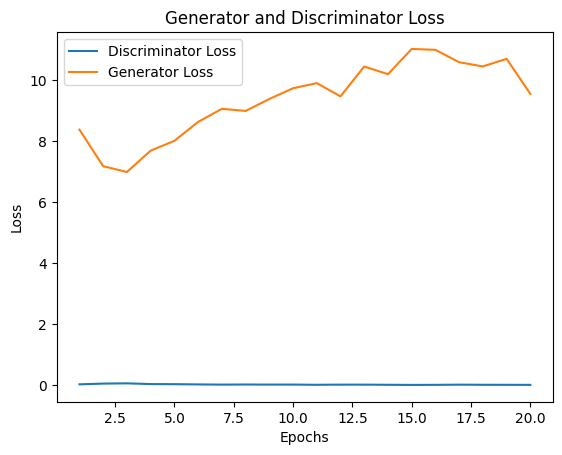

In [2]:

input_size = 64
input_channels = 1
img_channels = 64
latent_dim = 100
batch_size = 32
embed_dim =  20
num_classes = 10
img_size = input_size

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * input_channels, [0.5] * input_channels),
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
x_train = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

model = cond_DCGAN(latent_dim,embed_dim, input_channels, img_channels, batch_size,num_classes,img_size)
model.train(x_train)

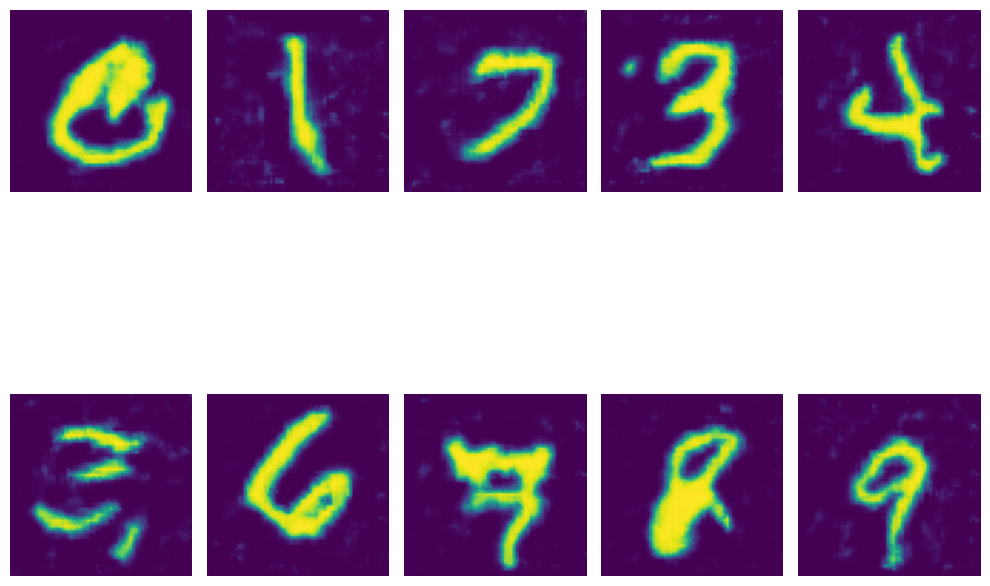

In [3]:
# Set the number of rows and columns for the grid
rows = 2
cols = 5

# Create a figure and axis objects for the grid
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Generate and plot images
for i in range(rows):
    for j in range(cols):
        img = model.sample(i*5 + j)
        img = img.cpu().detach().squeeze().numpy()
        img = img.reshape(64, 64)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

# Display the grid of images
plt.tight_layout()
plt.show()

<p>To improve the quality of the generated images, it is recommended to train the model for a longer duration and with a larger dataset. Increasing the number of training steps, adjusting the learning rate, and experimenting with different architectural changes or hyperparameter settings can also lead to better results.</p>

<p>It's important to note that assessing the quality of generated images is subjective, and the final judgment depends on specific requirements and expectations. Visual inspection of the generated images, along with feedback from domain experts or users, can provide valuable insights into the model's performance and guide further improvements.</p>